In [17]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from scipy.stats import multivariate_normal
import seaborn as sns
sns.set()
import mlflow

from tqdm import tqdm


## EM for Gaussian Mixture

In [62]:
@dataclass
class Params:
    pi: np.ndarray
    mu: list[np.ndarray]
    sigma: list[np.ndarray]


def E_step(y: np.ndarray, params: Params):
    N, D = y.shape
    K = params.pi.shape[0]
    gamma = np.zeros((N, K))
    for n in range(N):
        joint_probs = np.array([
            params.pi[k] * multivariate_normal.pdf(y[n], params.mu[k], params.sigma[k])
            for k in range(K)
        ]).reshape(-1,)
        assert joint_probs.shape == (K, )
        marginal_prob = joint_probs.sum()
        gamma[n] = joint_probs / marginal_prob
    return gamma

def M_step(y: np.ndarray, gamma: np.ndarray) -> Params:
    N, K = gamma.shape
    D = y.shape[1]
    new_params = Params(
        pi=np.zeros((K, )),
        mu=[np.zeros((K, D)) for _ in range(K)],
        sigma=[np.zeros((K, D, D)) for _ in range(K)]
    )
    new_params.pi = np.sum(gamma, axis=0) / np.sum(gamma)

    for k in range(K):
        new_mu_k = gamma[:, k].reshape(1, N)@y.reshape(N, D) / gamma[:, k].sum()
        new_mu_k = new_mu_k.reshape(D, )
        new_params.mu[k] = new_mu_k
        new_params.sigma[k] = np.array([
            (y[n] - new_mu_k).reshape(D, 1)@(y[n] - new_mu_k).reshape(1, D) * gamma[n, k]
            for n in range(N)
        ]).reshape(N, D, D).sum(axis=0) / gamma[:, k].sum()
    return new_params

def modified_M_step(y: np.ndarray, gamma: np.ndarray) -> Params:
    N, K = gamma.shape
    D = y.shape[1]
    new_params = Params(
        pi=np.zeros((K, )),
        mu=[np.zeros((K, D)) for _ in range(K)],
        sigma=[np.zeros((K, D, D)) for _ in range(K)]
    )

    eps = 1e-10
    # modified
    new_params.pi = np.sum(gamma, axis=0) / gamma.sum()
    for k in range(K):
        if new_params.pi[k] < eps:
            new_params.pi[k] = eps
        elif new_params.pi[k] > 1 - eps:
            new_params.pi[k] = 1 - eps
    for k in range(K):
        # modified
        new_mu_k = gamma[:, k].reshape(1, N)@y.reshape(N, D) / (gamma[:, k].sum() + 10 * eps)
        new_mu_k = new_mu_k.reshape(D, )
        new_params.mu[k] = new_mu_k
        # modified
        new_params.sigma[k] = np.array([
            (y[n] - new_mu_k).reshape(D, 1)@(y[n] - new_mu_k).reshape(1, D) * gamma[n, k]
            for n in range(N)
        ]).reshape(N, D, D).sum(axis=0) + np.eye(D) * eps
        new_params.sigma[k] /= (gamma[:, k].sum() + eps)
    return new_params

def marginal_log_likelihood(y: np.ndarray, params: Params) -> float:
    N, D = y.shape
    K = params.pi.shape[0]
    ll = 0
    for n in range(N):
        ll += np.log(np.array([
            params.pi[k] * multivariate_normal.pdf(y[n], params.mu[k], params.sigma[k])
            for k in range(K)
        ]).sum())
    return ll

def params_generator(rng: np.random.Generator, D: int, K: int) -> Params:
    pi = rng.dirichlet(np.ones(K), size=1).reshape(K, )
    mu = rng.uniform(-10, 10, (K, D))
    sigma = [
        np.eye(D) * rng.uniform(1, 10)
        for _ in range(K)
    ]
    return Params(pi, mu, sigma)

def generate_sample_gm(rng: np.random.Generator, params: Params, N: int):
    D = params.mu[0].shape[0]
    K = params.mu.shape[0]
    z = rng.choice(K, size=N, p=params.pi)
    y = np.array([
        rng.multivariate_normal(params.mu[k], params.sigma[k])
        for k in z
    ])

    return np.concatenate(y, axis=0).reshape(N, D)


# D = 1

true: Params(pi=array([0.83609177, 0.16390823]), mu=array([[-5.59280254],
       [-6.31256379]]), sigma=[array([[2.58315311]]), array([[8.30885056]])])
init: Params(pi=array([0.66429965, 0.33570035]), mu=array([[8.90980456],
       [0.27096941]]), sigma=[array([[1.81968124]]), array([[7.56569704]])])


100%|██████████| 100/100 [00:03<00:00, 31.30it/s]


estimated: Params(pi=array([0.0049999, 0.9950001]), mu=[array([-0.46787861]), array([-5.67940443])], sigma=[array([[1.00001967e-10]]), array([[3.38944412]])])


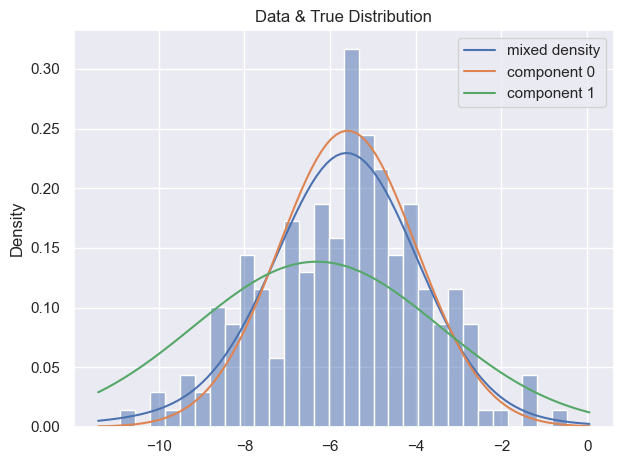

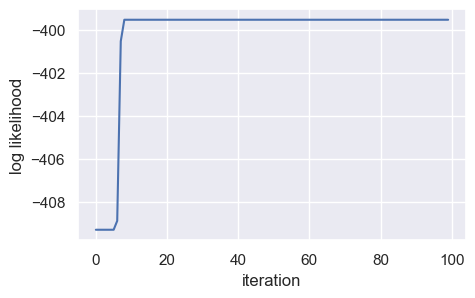

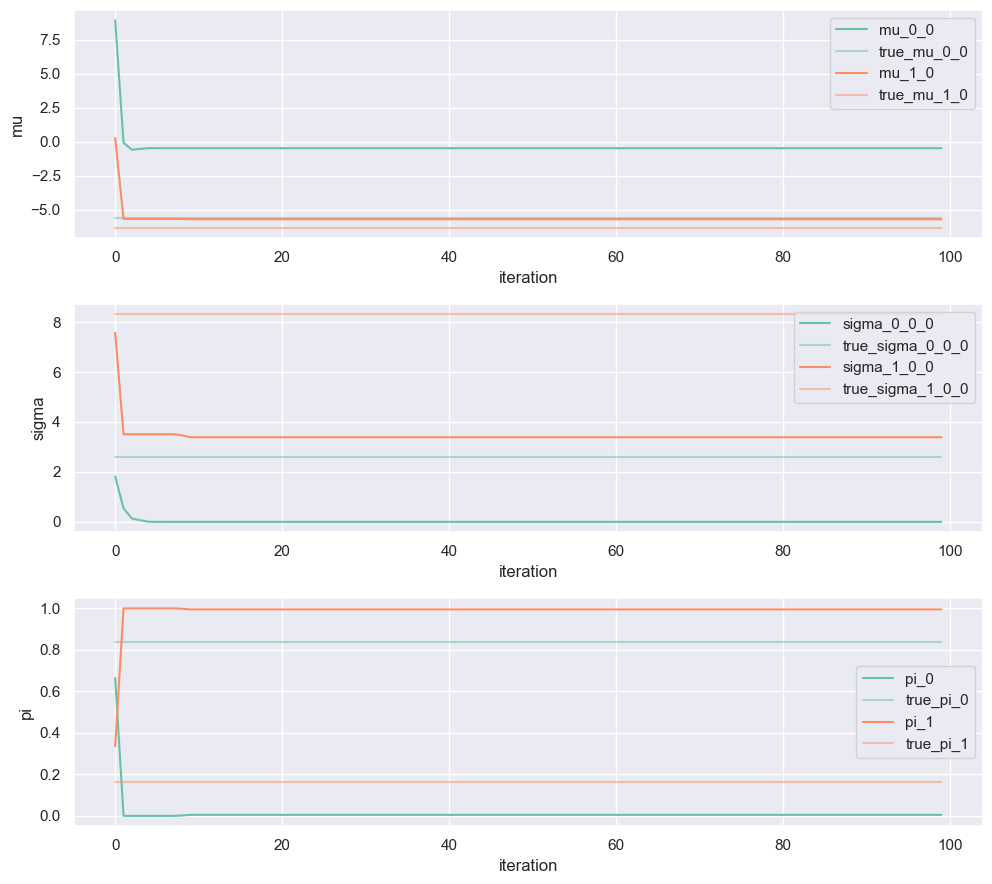

In [82]:
K = 2
N = 200
D = 1

rng = np.random.default_rng(123)

true_params = params_generator(rng, D, K)
data = generate_sample_gm(rng, true_params, N)
print(f"true: {true_params}")
fig, ax = plt.subplots()
# plot data
sns.histplot(data, bins=30, ax=ax, stat='density')
# plot true distribution
x = np.linspace(*ax.get_xlim(), 100)
density = np.zeros((len(x), ))
for k in range(K):
    density += true_params.pi[k] * multivariate_normal.pdf(x, true_params.mu[k], true_params.sigma[k])
ax.plot(x, density, label="mixed density")
for k in range(K):
    ax.plot(x, multivariate_normal.pdf(x, true_params.mu[k], true_params.sigma[k]), label=f"component {k}")
ax.legend()
ax.set_title("Data & True Distribution")
fig.tight_layout()

initial = params_generator(rng, D, K)
print(f"init: {initial}")

EM_MAX_ITR = 100

params = initial
# params = true_params
ll_list = []
params_list = []
for _ in tqdm(range(EM_MAX_ITR)):
    params_list.append(params)
    gamma = E_step(data, params)
    params = modified_M_step(data, gamma)
    ll_list.append(marginal_log_likelihood(data, params))
    # if len(ll_list) > 1 and ll_list[-1] - ll_list[-2] < 1e-6:
    #     break

print(f"estimated: {params}")

# plot log likelihood
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.set_xlabel("iteration")
ax.set_ylabel("log likelihood")
sns.lineplot(ll_list, ax=ax)
# plot params_list
num_axs = D*3
fig, axs = plt.subplots(num_axs, 1, figsize=(10, 3*num_axs))
axs = axs.reshape(D, 3)
colors = sns.color_palette("Set2", K)
# mu
for i in range(D):
    for k in range(K):
        axs[i][0].plot([params.mu[k][i] for params in params_list], label=f"mu_{k}_{i}", c=colors[k])
        axs[i][0].plot([true_params.mu[k][i]]*len(params_list), label=f"true_mu_{k}_{i}", alpha=0.5, c=colors[k])
    axs[i][0].set_xlabel("iteration")
    axs[i][0].set_ylabel("mu")
    axs[i][0].legend()

# diag of sigma
for i in range(D):
    for k in range(K):
        axs[i][1].plot([params.sigma[k][i][i] for params in params_list], label=f"sigma_{k}_{i}_{i}", c=colors[k])
        axs[i][1].plot([true_params.sigma[k][i][i]]*len(params_list), label=f"true_sigma_{k}_{i}_{i}", alpha=0.5, c=colors[k])
    axs[i][1].set_xlabel("iteration")
    axs[i][1].set_ylabel("sigma")
    axs[i][1].legend()

# pi
for k in range(K):
    axs[0][2].plot([params.pi[k] for params in params_list], label=f"pi_{k}", c=colors[k])
    axs[0][2].plot([true_params.pi[k]]*len(params_list), label=f"true_pi_{k}", alpha=0.5, c=colors[k])
    axs[0][2].set_xlabel("iteration")
    axs[0][2].set_ylabel("pi")
    axs[0][2].legend()

fig.tight_layout()



# D = 2

## trueが初期値

true: Params(pi=array([0.83609177, 0.16390823]), mu=array([[-5.59280254, -6.31256379],
       [-6.48188198,  6.24189013]]), sigma=[array([[9.31010498, 0.        ],
       [0.        , 9.31010498]]), array([[3.48916958, 0.        ],
       [0.        , 3.48916958]])])
init: Params(pi=array([0.83609177, 0.16390823]), mu=array([[-5.59280254, -6.31256379],
       [-6.48188198,  6.24189013]]), sigma=[array([[9.31010498, 0.        ],
       [0.        , 9.31010498]]), array([[3.48916958, 0.        ],
       [0.        , 3.48916958]])])


100%|██████████| 100/100 [00:01<00:00, 64.18it/s]


estimated: Params(pi=array([0.86005018, 0.13994982]), mu=[array([-5.50219143, -6.3165535 ]), array([-6.72497292,  6.65794474])], sigma=[array([[10.88585813,  1.05811334],
       [ 1.05811334,  8.08618072]]), array([[3.11822071, 0.17033375],
       [0.17033375, 2.14706866]])])


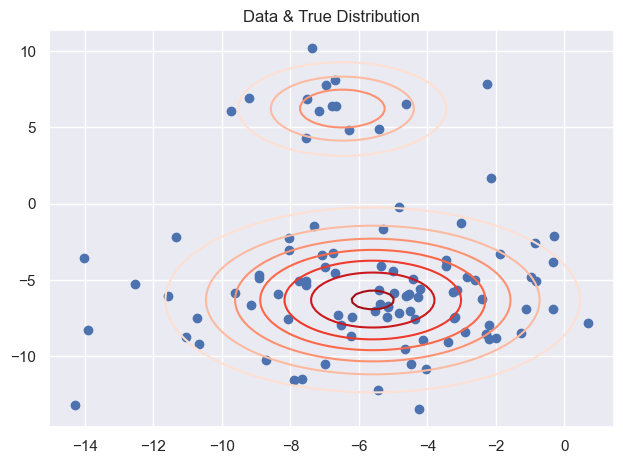

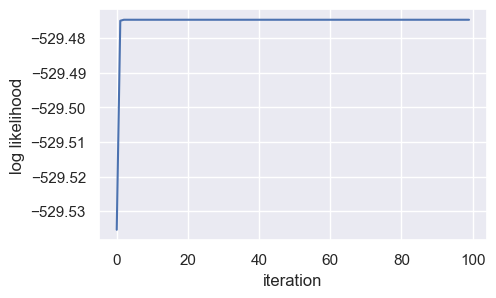

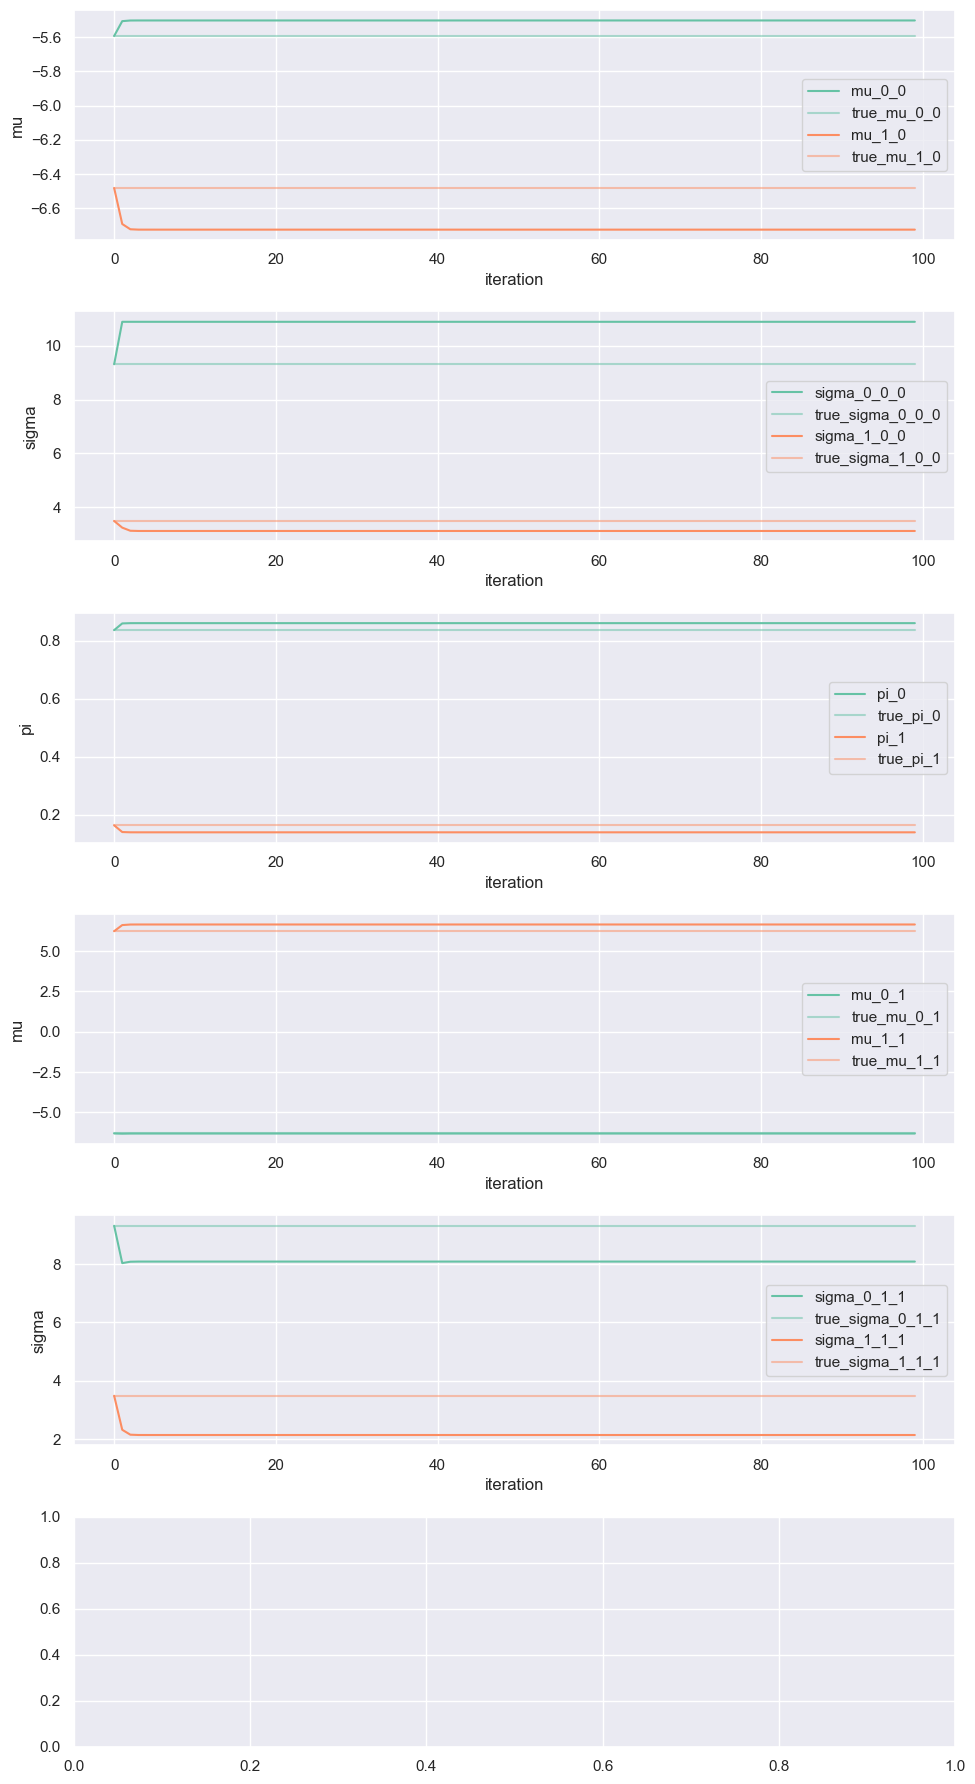

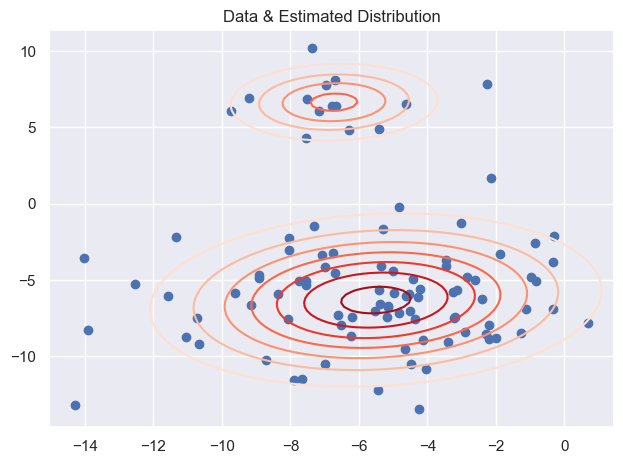

In [64]:
K = 2
N = 100
D = 2

rng = np.random.default_rng(123)

true_params = params_generator(rng, D, K)
data = generate_sample_gm(rng, true_params, N)
print(f"true: {true_params}")
fig, ax = plt.subplots()

if D == 1:
    # plot data
    sns.histplot(data, bins=30, ax=ax, stat='density')
    # plot true distribution
    x = np.linspace(*ax.get_xlim(), 100)
    density = np.zeros((len(x), ))
    for k in range(K):
        density += true_params.pi[k] * multivariate_normal.pdf(x, true_params.mu[k], true_params.sigma[k])
    ax.plot(x, density, label="mixed density")
    for k in range(K):
        ax.plot(x, multivariate_normal.pdf(x, true_params.mu[k], true_params.sigma[k]), label=f"component {k}")
    ax.legend()
    ax.set_title("Data & True Distribution")
    fig.tight_layout()
if D == 2:
    # plot data
    ax.scatter(data[:, 0], data[:, 1])
    # plot true distribution
    x1 = np.linspace(*ax.get_xlim(), 100)
    x2 = np.linspace(*ax.get_ylim(), 100)
    X1, X2 = np.meshgrid(x1, x2)
    density = np.zeros((len(x1), len(x2)))
    for k in range(K):
        density += true_params.pi[k] * multivariate_normal.pdf(np.stack([X1, X2], axis=2), true_params.mu[k], true_params.sigma[k])
    ax.contour(X1, X2, density, cmap='Reds')
    ax.set_title("Data & True Distribution")
    fig.tight_layout()


# initial = params_generator(rng, D, K)
initial = true_params
print(f"init: {initial}")

EM_MAX_ITR = 100

params = initial
ll_list = []
params_list = []
for _ in tqdm(range(EM_MAX_ITR)):
    params_list.append(params)
    gamma = E_step(data, params)
    params = M_step(data, gamma)
    ll_list.append(marginal_log_likelihood(data, params))
    # if len(ll_list) > 1 and ll_list[-1] - ll_list[-2] < 1e-6:
    #     break

print(f"estimated: {params}")

# plot log likelihood
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.set_xlabel("iteration")
ax.set_ylabel("log likelihood")
sns.lineplot(ll_list, ax=ax)
# plot params_list
num_axs = D*3
fig, axs = plt.subplots(num_axs, 1, figsize=(10, 3*num_axs))
axs = axs.reshape(D, 3)
colors = sns.color_palette("Set2", K)
# mu
for i in range(D):
    for k in range(K):
        axs[i][0].plot([params.mu[k][i] for params in params_list], label=f"mu_{k}_{i}", c=colors[k])
        axs[i][0].plot([true_params.mu[k][i]]*len(params_list), label=f"true_mu_{k}_{i}", alpha=0.5, c=colors[k])
    axs[i][0].set_xlabel("iteration")
    axs[i][0].set_ylabel("mu")
    axs[i][0].legend()

# diag of sigma
for i in range(D):
    for k in range(K):
        axs[i][1].plot([params.sigma[k][i][i] for params in params_list], label=f"sigma_{k}_{i}_{i}", c=colors[k])
        axs[i][1].plot([true_params.sigma[k][i][i]]*len(params_list), label=f"true_sigma_{k}_{i}_{i}", alpha=0.5, c=colors[k])
    axs[i][1].set_xlabel("iteration")
    axs[i][1].set_ylabel("sigma")
    axs[i][1].legend()

# pi
for k in range(K):
    axs[0][2].plot([params.pi[k] for params in params_list], label=f"pi_{k}", c=colors[k])
    axs[0][2].plot([true_params.pi[k]]*len(params_list), label=f"true_pi_{k}", alpha=0.5, c=colors[k])
    axs[0][2].set_xlabel("iteration")
    axs[0][2].set_ylabel("pi")
    axs[0][2].legend()

fig.tight_layout()


if D == 2:
    fig, ax = plt.subplots()
    # plot data
    ax.scatter(data[:, 0], data[:, 1])
    # plot true distribution
    x1 = np.linspace(*ax.get_xlim(), 100)
    x2 = np.linspace(*ax.get_ylim(), 100)
    X1, X2 = np.meshgrid(x1, x2)
    density = np.zeros((len(x1), len(x2)))
    for k in range(K):
        density += params.pi[k] * multivariate_normal.pdf(np.stack([X1, X2], axis=2), params.mu[k], params.sigma[k])
    ax.contour(X1, X2, density, cmap='Reds')
    ax.set_title("Data & Estimated Distribution")
    fig.tight_layout()


## 変な初期値だとM-stepの正則化が必要

true: Params(pi=array([0.83609177, 0.16390823]), mu=array([[-5.59280254, -6.31256379],
       [-6.48188198,  6.24189013]]), sigma=[array([[9.31010498, 0.        ],
       [0.        , 9.31010498]]), array([[3.48916958, 0.        ],
       [0.        , 3.48916958]])])
init: Params(pi=array([0.92716792, 0.07283208]), mu=array([[ 8.640496  , -2.30016575],
       [-3.52439703,  8.01952658]]), sigma=[array([[1.42638484, 0.        ],
       [0.        , 1.42638484]]), array([[9.79871431, 0.        ],
       [0.        , 9.79871431]])])


  2%|▏         | 2/100 [00:00<00:02, 46.27it/s]


LinAlgError: When `allow_singular is False`, the input matrix must be symmetric positive definite.

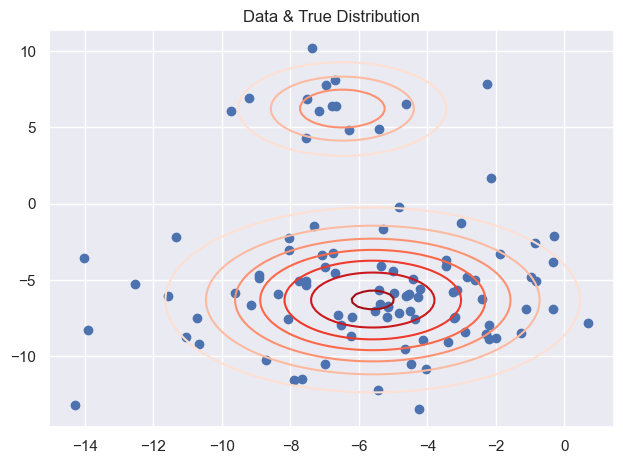

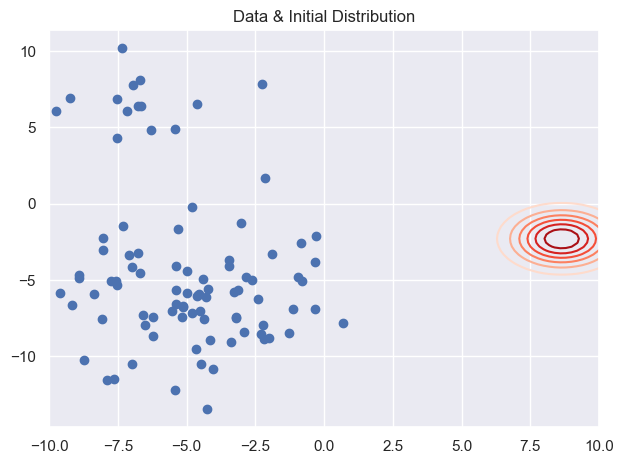

In [83]:
K = 2
N = 100
D = 2

rng = np.random.default_rng(123)

true_params = params_generator(rng, D, K)
data = generate_sample_gm(rng, true_params, N)
print(f"true: {true_params}")
fig, ax = plt.subplots()

if D == 1:
    # plot data
    sns.histplot(data, bins=30, ax=ax, stat='density')
    # plot true distribution
    x = np.linspace(*ax.get_xlim(), 100)
    density = np.zeros((len(x), ))
    for k in range(K):
        density += true_params.pi[k] * multivariate_normal.pdf(x, true_params.mu[k], true_params.sigma[k])
    ax.plot(x, density, label="mixed density")
    for k in range(K):
        ax.plot(x, multivariate_normal.pdf(x, true_params.mu[k], true_params.sigma[k]), label=f"component {k}")
    ax.legend()
    ax.set_title("Data & True Distribution")
    fig.tight_layout()
if D == 2:
    # plot data
    ax.scatter(data[:, 0], data[:, 1])
    # plot true distribution
    x1 = np.linspace(*ax.get_xlim(), 100)
    x2 = np.linspace(*ax.get_ylim(), 100)
    X1, X2 = np.meshgrid(x1, x2)
    density = np.zeros((len(x1), len(x2)))
    for k in range(K):
        density += true_params.pi[k] * multivariate_normal.pdf(np.stack([X1, X2], axis=2), true_params.mu[k], true_params.sigma[k])
    ax.contour(X1, X2, density, cmap='Reds')
    ax.set_title("Data & True Distribution")
    fig.tight_layout()


# initial = params_generator(rng, D, K)
initial = params_generator(rng, D, K)
print(f"init: {initial}")
if D == 2:
    fig, ax = plt.subplots()
    # plot data
    ax.scatter(data[:, 0], data[:, 1])
    ax.set_xlim(-10, 10)
    # plot true distribution
    x1 = np.linspace(*ax.get_xlim(), 100)
    x2 = np.linspace(*ax.get_ylim(), 100)
    X1, X2 = np.meshgrid(x1, x2)
    density = np.zeros((len(x1), len(x2)))
    for k in range(K):
        density += initial.pi[k] * multivariate_normal.pdf(np.stack([X1, X2], axis=2), initial.mu[k], initial.sigma[k])
    ax.contour(X1, X2, density, cmap='Reds')
    ax.set_title("Data & Initial Distribution")
    fig.tight_layout()


EM_MAX_ITR = 100

params = initial
ll_list = []
params_list = []
for _ in tqdm(range(EM_MAX_ITR)):
    params_list.append(params)
    gamma = E_step(data, params)
    params = M_step(data, gamma)
    ll_list.append(marginal_log_likelihood(data, params))
    # if len(ll_list) > 1 and ll_list[-1] - ll_list[-2] < 1e-6:
    #     break

print(f"estimated: {params}")

# plot log likelihood
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.set_xlabel("iteration")
ax.set_ylabel("log likelihood")
sns.lineplot(ll_list, ax=ax)
# plot params_list
num_axs = D*3
fig, axs = plt.subplots(num_axs, 1, figsize=(10, 3*num_axs))
axs = axs.reshape(D, 3)
colors = sns.color_palette("Set2", K)
# mu
for i in range(D):
    for k in range(K):
        axs[i][0].plot([params.mu[k][i] for params in params_list], label=f"mu_{k}_{i}", c=colors[k])
        axs[i][0].plot([true_params.mu[k][i]]*len(params_list), label=f"true_mu_{k}_{i}", alpha=0.5, c=colors[k])
    axs[i][0].set_xlabel("iteration")
    axs[i][0].set_ylabel("mu")
    axs[i][0].legend()

# diag of sigma
for i in range(D):
    for k in range(K):
        axs[i][1].plot([params.sigma[k][i][i] for params in params_list], label=f"sigma_{k}_{i}_{i}", c=colors[k])
        axs[i][1].plot([true_params.sigma[k][i][i]]*len(params_list), label=f"true_sigma_{k}_{i}_{i}", alpha=0.5, c=colors[k])
    axs[i][1].set_xlabel("iteration")
    axs[i][1].set_ylabel("sigma")
    axs[i][1].legend()

# pi
for k in range(K):
    axs[0][2].plot([params.pi[k] for params in params_list], label=f"pi_{k}", c=colors[k])
    axs[0][2].plot([true_params.pi[k]]*len(params_list), label=f"true_pi_{k}", alpha=0.5, c=colors[k])
    axs[0][2].set_xlabel("iteration")
    axs[0][2].set_ylabel("pi")
    axs[0][2].legend()

fig.tight_layout()


if D == 2:
    fig, ax = plt.subplots()
    # plot data
    ax.scatter(data[:, 0], data[:, 1])
    # plot true distribution
    x1 = np.linspace(*ax.get_xlim(), 100)
    x2 = np.linspace(*ax.get_ylim(), 100)
    X1, X2 = np.meshgrid(x1, x2)
    density = np.zeros((len(x1), len(x2)))
    for k in range(K):
        density += params.pi[k] * multivariate_normal.pdf(np.stack([X1, X2], axis=2), params.mu[k], params.sigma[k])
    ax.contour(X1, X2, density, cmap='Reds')
    ax.set_title("Data & Estimated Distribution")
    fig.tight_layout()


## 上と全く同一条件で、M-stepを正則化

true: Params(pi=array([0.83609177, 0.16390823]), mu=array([[-5.59280254, -6.31256379],
       [-6.48188198,  6.24189013]]), sigma=[array([[9.31010498, 0.        ],
       [0.        , 9.31010498]]), array([[3.48916958, 0.        ],
       [0.        , 3.48916958]])])
init: Params(pi=array([0.92716792, 0.07283208]), mu=array([[ 8.640496  , -2.30016575],
       [-3.52439703,  8.01952658]]), sigma=[array([[1.42638484, 0.        ],
       [0.        , 1.42638484]]), array([[9.79871431, 0.        ],
       [0.        , 9.79871431]])])


100%|██████████| 100/100 [00:01<00:00, 65.96it/s]


estimated: Params(pi=array([0.01, 0.99]), mu=[array([ 0.6986985 , -7.81241684]), array([-5.7376833 , -4.46732391])], sigma=[array([[ 1.00000000e-10, -5.45852402e-18],
       [-5.45852402e-18,  1.00000061e-10]]), array([[ 9.6652714 , -0.77025373],
       [-0.77025373, 27.68281864]])])


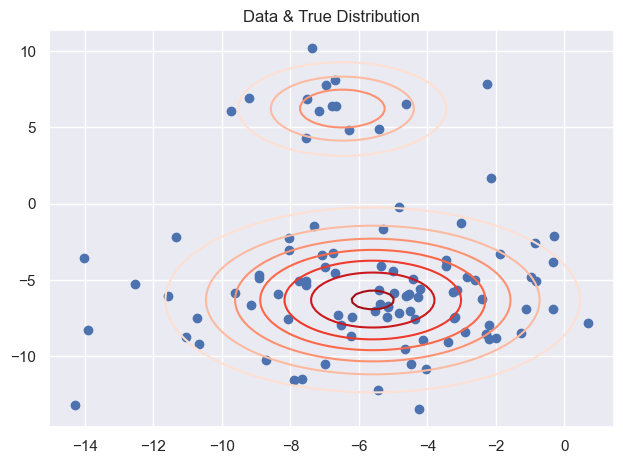

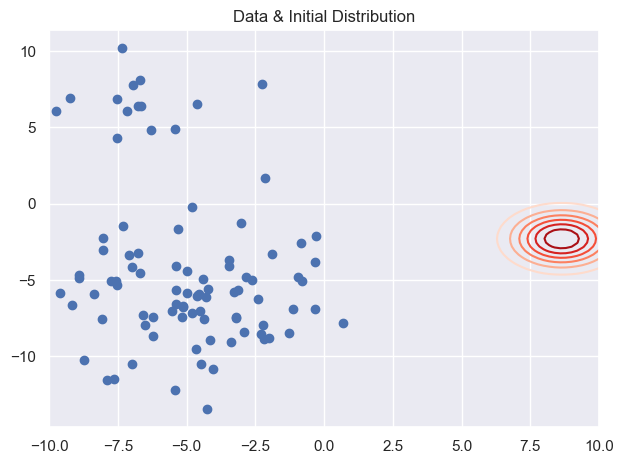

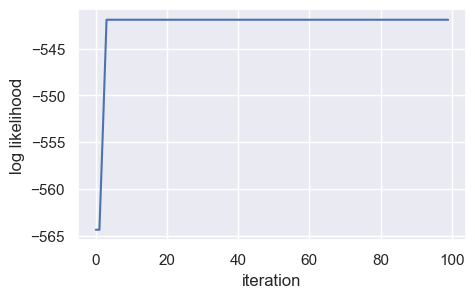

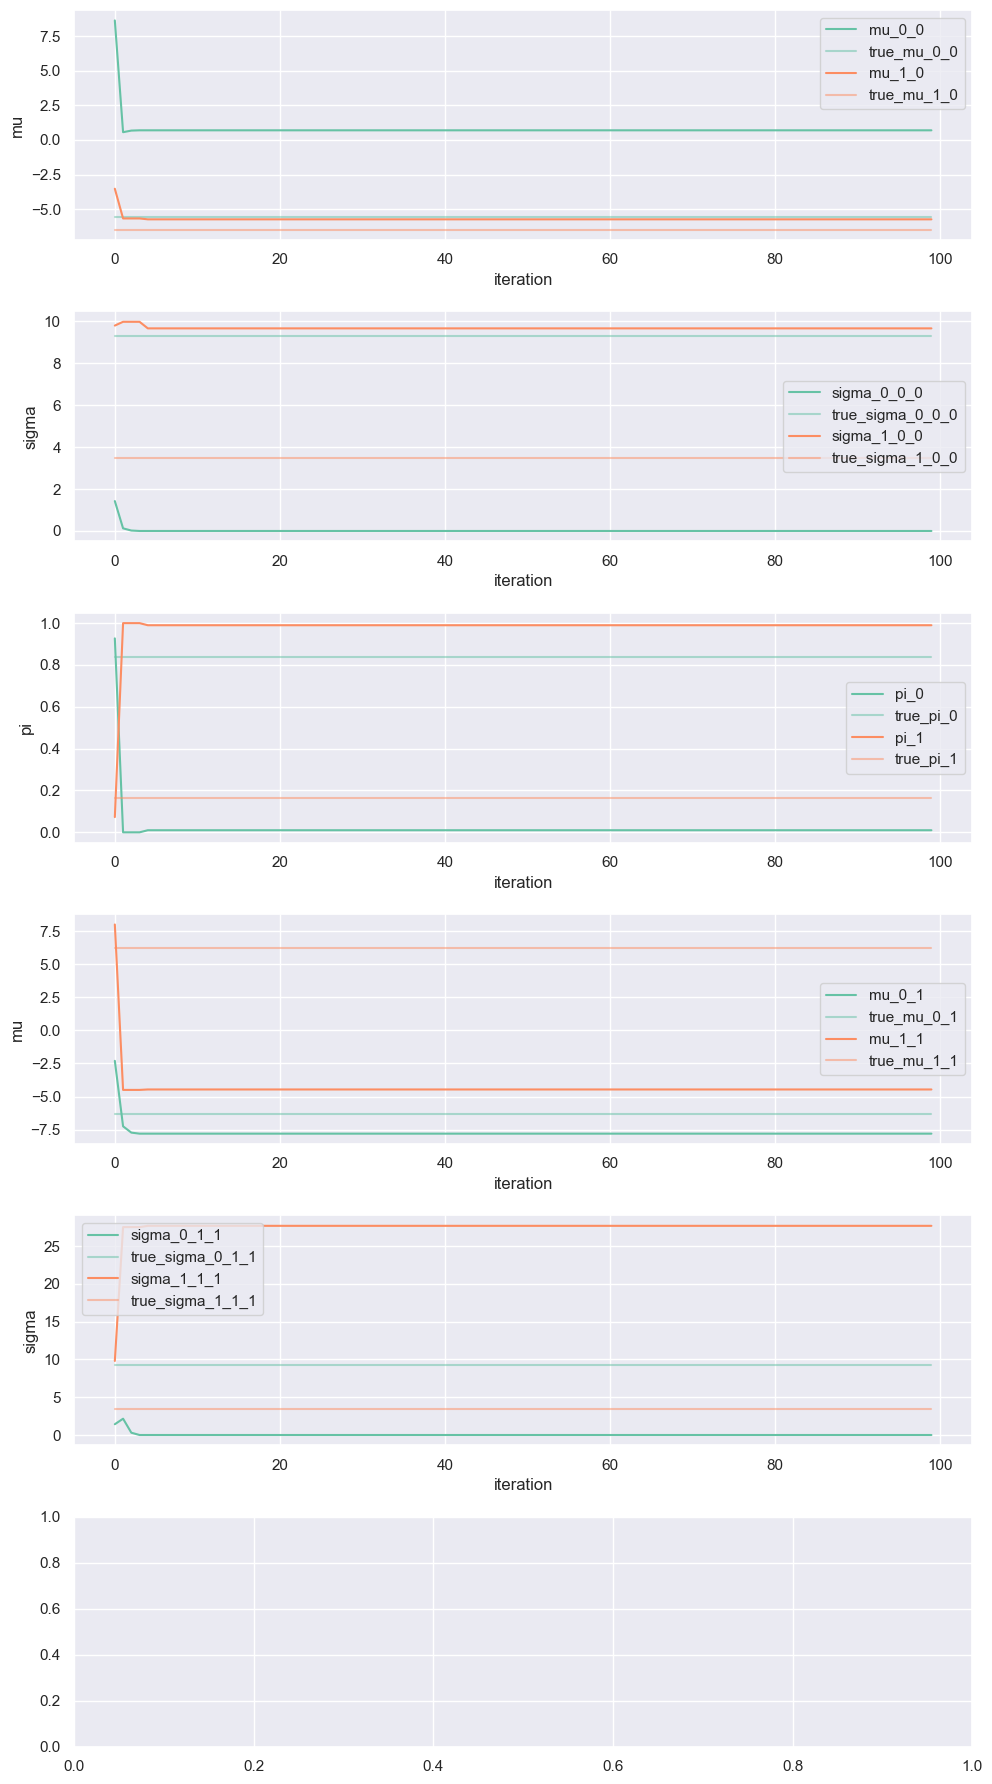

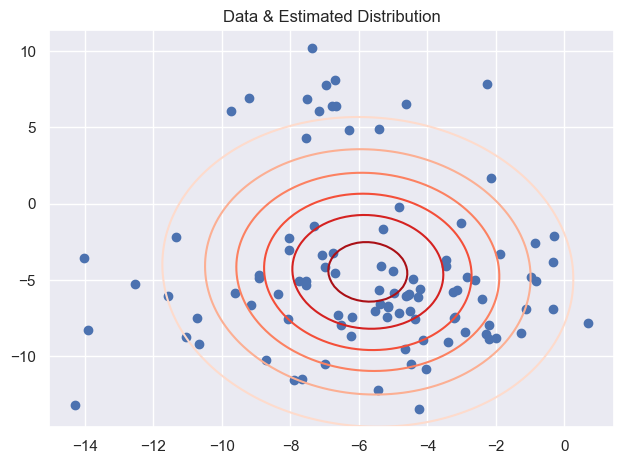

In [72]:
K = 2
N = 100
D = 2

rng = np.random.default_rng(123)

true_params = params_generator(rng, D, K)
data = generate_sample_gm(rng, true_params, N)
print(f"true: {true_params}")
fig, ax = plt.subplots()

if D == 1:
    # plot data
    sns.histplot(data, bins=30, ax=ax, stat='density')
    # plot true distribution
    x = np.linspace(*ax.get_xlim(), 100)
    density = np.zeros((len(x), ))
    for k in range(K):
        density += true_params.pi[k] * multivariate_normal.pdf(x, true_params.mu[k], true_params.sigma[k])
    ax.plot(x, density, label="mixed density")
    for k in range(K):
        ax.plot(x, multivariate_normal.pdf(x, true_params.mu[k], true_params.sigma[k]), label=f"component {k}")
    ax.legend()
    ax.set_title("Data & True Distribution")
    fig.tight_layout()
if D == 2:
    # plot data
    ax.scatter(data[:, 0], data[:, 1])
    # plot true distribution
    x1 = np.linspace(*ax.get_xlim(), 100)
    x2 = np.linspace(*ax.get_ylim(), 100)
    X1, X2 = np.meshgrid(x1, x2)
    density = np.zeros((len(x1), len(x2)))
    for k in range(K):
        density += true_params.pi[k] * multivariate_normal.pdf(np.stack([X1, X2], axis=2), true_params.mu[k], true_params.sigma[k])
    ax.contour(X1, X2, density, cmap='Reds')
    ax.set_title("Data & True Distribution")
    fig.tight_layout()


# initial = params_generator(rng, D, K)
initial = params_generator(rng, D, K)
print(f"init: {initial}")
if D == 2:
    fig, ax = plt.subplots()
    # plot data
    ax.scatter(data[:, 0], data[:, 1])
    ax.set_xlim(-10, 10)
    # plot true distribution
    x1 = np.linspace(*ax.get_xlim(), 100)
    x2 = np.linspace(*ax.get_ylim(), 100)
    X1, X2 = np.meshgrid(x1, x2)
    density = np.zeros((len(x1), len(x2)))
    for k in range(K):
        density += initial.pi[k] * multivariate_normal.pdf(np.stack([X1, X2], axis=2), initial.mu[k], initial.sigma[k])
    ax.contour(X1, X2, density, cmap='Reds')
    ax.set_title("Data & Initial Distribution")
    fig.tight_layout()


EM_MAX_ITR = 100

params = initial
ll_list = []
params_list = []
for _ in tqdm(range(EM_MAX_ITR)):
    params_list.append(params)
    gamma = E_step(data, params)
    params = modified_M_step(data, gamma)
    ll_list.append(marginal_log_likelihood(data, params))
    # if len(ll_list) > 1 and ll_list[-1] - ll_list[-2] < 1e-6:
    #     break

print(f"estimated: {params}")

# plot log likelihood
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.set_xlabel("iteration")
ax.set_ylabel("log likelihood")
sns.lineplot(ll_list, ax=ax)
# plot params_list
num_axs = D*3
fig, axs = plt.subplots(num_axs, 1, figsize=(10, 3*num_axs))
axs = axs.reshape(D, 3)
colors = sns.color_palette("Set2", K)
# mu
for i in range(D):
    for k in range(K):
        axs[i][0].plot([params.mu[k][i] for params in params_list], label=f"mu_{k}_{i}", c=colors[k])
        axs[i][0].plot([true_params.mu[k][i]]*len(params_list), label=f"true_mu_{k}_{i}", alpha=0.5, c=colors[k])
    axs[i][0].set_xlabel("iteration")
    axs[i][0].set_ylabel("mu")
    axs[i][0].legend()

# diag of sigma
for i in range(D):
    for k in range(K):
        axs[i][1].plot([params.sigma[k][i][i] for params in params_list], label=f"sigma_{k}_{i}_{i}", c=colors[k])
        axs[i][1].plot([true_params.sigma[k][i][i]]*len(params_list), label=f"true_sigma_{k}_{i}_{i}", alpha=0.5, c=colors[k])
    axs[i][1].set_xlabel("iteration")
    axs[i][1].set_ylabel("sigma")
    axs[i][1].legend()

# pi
for k in range(K):
    axs[0][2].plot([params.pi[k] for params in params_list], label=f"pi_{k}", c=colors[k])
    axs[0][2].plot([true_params.pi[k]]*len(params_list), label=f"true_pi_{k}", alpha=0.5, c=colors[k])
    axs[0][2].set_xlabel("iteration")
    axs[0][2].set_ylabel("pi")
    axs[0][2].legend()

fig.tight_layout()


if D == 2:
    fig, ax = plt.subplots()
    # plot data
    ax.scatter(data[:, 0], data[:, 1])
    # plot true distribution
    x1 = np.linspace(*ax.get_xlim(), 100)
    x2 = np.linspace(*ax.get_ylim(), 100)
    X1, X2 = np.meshgrid(x1, x2)
    density = np.zeros((len(x1), len(x2)))
    for k in range(K):
        density += params.pi[k] * multivariate_normal.pdf(np.stack([X1, X2], axis=2), params.mu[k], params.sigma[k])
    ax.contour(X1, X2, density, cmap='Reds')
    ax.set_title("Data & Estimated Distribution")
    fig.tight_layout()


## 同一条件だが、muとpiの初期値をいじってみる

true: Params(pi=array([0.83609177, 0.16390823]), mu=array([[-5.59280254, -6.31256379],
       [-6.48188198,  6.24189013]]), sigma=[array([[9.31010498, 0.        ],
       [0.        , 9.31010498]]), array([[3.48916958, 0.        ],
       [0.        , 3.48916958]])])
init: Params(pi=array([0.5, 0.5]), mu=array([[ 8.640496  , -2.30016575],
       [-3.52439703,  8.01952658]]), sigma=[array([[10.0795415 , -0.98555668],
       [-0.98555668, 27.7947151 ]]), array([[10.0795415 , -0.98555668],
       [-0.98555668, 27.7947151 ]])])


100%|██████████| 100/100 [00:01<00:00, 63.45it/s]


estimated: Params(pi=array([0.76352433, 0.23647567]), mu=[array([-4.79248358, -6.38133014]), array([-8.5173315 ,  1.57109604])], sigma=[array([[6.87991768, 0.92251904],
       [0.92251904, 7.54466526]]), array([[ 9.39062211, 15.512188  ],
       [15.512188  , 43.71588644]])])


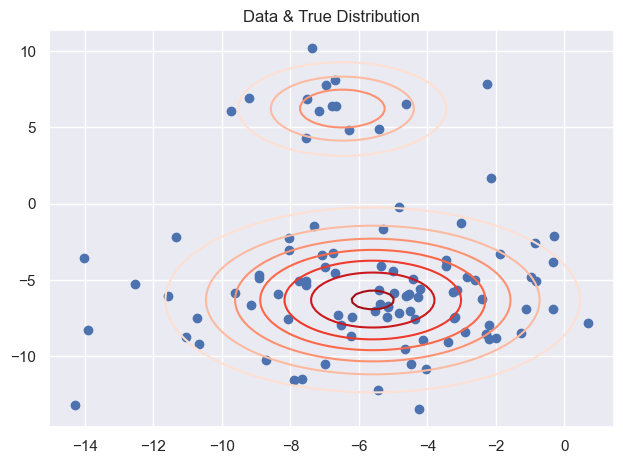

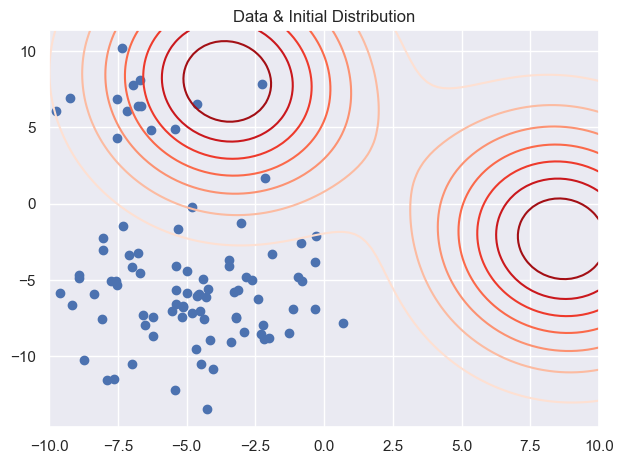

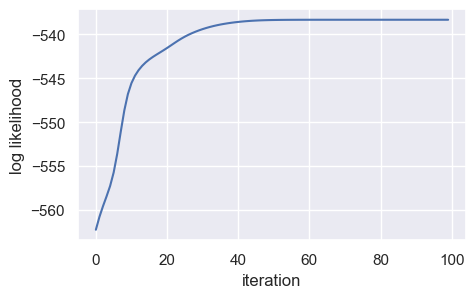

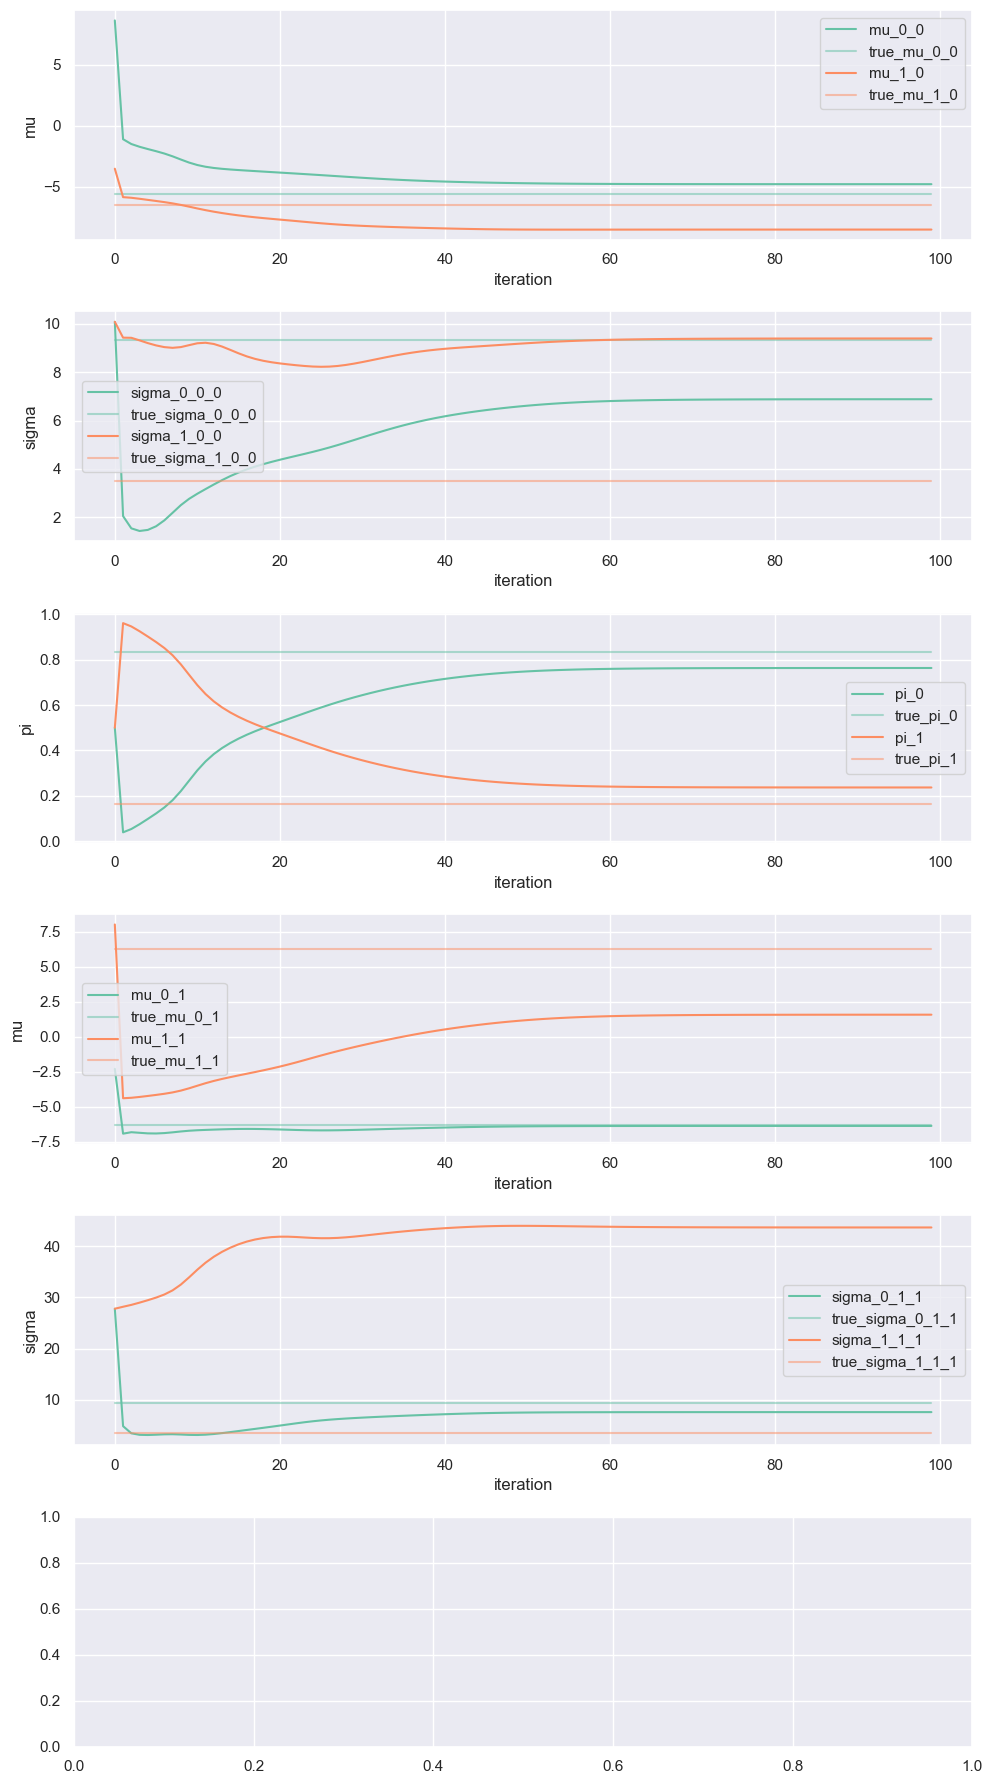

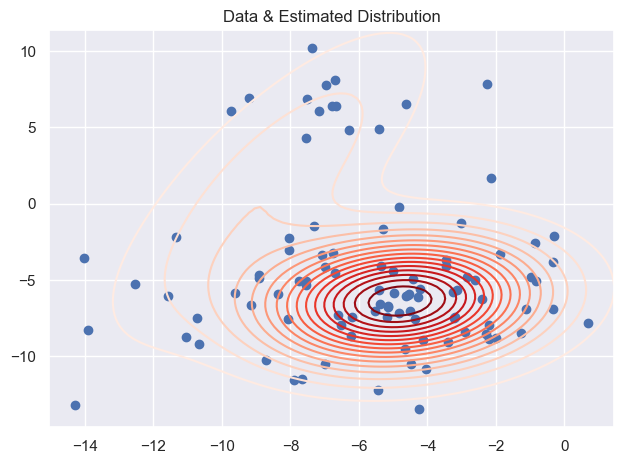

In [84]:
K = 2
N = 100
D = 2

rng = np.random.default_rng(123)

true_params = params_generator(rng, D, K)
data = generate_sample_gm(rng, true_params, N)
print(f"true: {true_params}")
fig, ax = plt.subplots()

if D == 1:
    # plot data
    sns.histplot(data, bins=30, ax=ax, stat='density')
    # plot true distribution
    x = np.linspace(*ax.get_xlim(), 100)
    density = np.zeros((len(x), ))
    for k in range(K):
        density += true_params.pi[k] * multivariate_normal.pdf(x, true_params.mu[k], true_params.sigma[k])
    ax.plot(x, density, label="mixed density")
    for k in range(K):
        ax.plot(x, multivariate_normal.pdf(x, true_params.mu[k], true_params.sigma[k]), label=f"component {k}")
    ax.legend()
    ax.set_title("Data & True Distribution")
    fig.tight_layout()
if D == 2:
    # plot data
    ax.scatter(data[:, 0], data[:, 1])
    # plot true distribution
    x1 = np.linspace(*ax.get_xlim(), 100)
    x2 = np.linspace(*ax.get_ylim(), 100)
    X1, X2 = np.meshgrid(x1, x2)
    density = np.zeros((len(x1), len(x2)))
    for k in range(K):
        density += true_params.pi[k] * multivariate_normal.pdf(np.stack([X1, X2], axis=2), true_params.mu[k], true_params.sigma[k])
    ax.contour(X1, X2, density, cmap='Reds')
    ax.set_title("Data & True Distribution")
    fig.tight_layout()


# initial = params_generator(rng, D, K)
initial = params_generator(rng, D, K)
initial.pi = np.array([0.5, 0.5])
initial.sigma = [np.cov(data, rowvar=False)] * K
print(f"init: {initial}")
if D == 2:
    fig, ax = plt.subplots()
    # plot data
    ax.scatter(data[:, 0], data[:, 1])
    # plot true distribution
    ax.set_xlim(-10, 10)
    x1 = np.linspace(*ax.get_xlim(), 100)
    x2 = np.linspace(*ax.get_ylim(), 100)
    X1, X2 = np.meshgrid(x1, x2)
    density = np.zeros((len(x1), len(x2)))
    for k in range(K):
        density += initial.pi[k] * multivariate_normal.pdf(np.stack([X1, X2], axis=2), initial.mu[k], initial.sigma[k])
    ax.contour(X1, X2, density, cmap='Reds')
    ax.set_title("Data & Initial Distribution")
    fig.tight_layout()


EM_MAX_ITR = 100

params = initial
ll_list = []
params_list = []
for _ in tqdm(range(EM_MAX_ITR)):
    params_list.append(params)
    gamma = E_step(data, params)
    params = modified_M_step(data, gamma)
    ll_list.append(marginal_log_likelihood(data, params))
    # if len(ll_list) > 1 and ll_list[-1] - ll_list[-2] < 1e-6:
    #     break

print(f"estimated: {params}")

# plot log likelihood
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.set_xlabel("iteration")
ax.set_ylabel("log likelihood")
sns.lineplot(ll_list, ax=ax)
# plot params_list
num_axs = D*3
fig, axs = plt.subplots(num_axs, 1, figsize=(10, 3*num_axs))
axs = axs.reshape(D, 3)
colors = sns.color_palette("Set2", K)
# mu
for i in range(D):
    for k in range(K):
        axs[i][0].plot([params.mu[k][i] for params in params_list], label=f"mu_{k}_{i}", c=colors[k])
        axs[i][0].plot([true_params.mu[k][i]]*len(params_list), label=f"true_mu_{k}_{i}", alpha=0.5, c=colors[k])
    axs[i][0].set_xlabel("iteration")
    axs[i][0].set_ylabel("mu")
    axs[i][0].legend()

# diag of sigma
for i in range(D):
    for k in range(K):
        axs[i][1].plot([params.sigma[k][i][i] for params in params_list], label=f"sigma_{k}_{i}_{i}", c=colors[k])
        axs[i][1].plot([true_params.sigma[k][i][i]]*len(params_list), label=f"true_sigma_{k}_{i}_{i}", alpha=0.5, c=colors[k])
    axs[i][1].set_xlabel("iteration")
    axs[i][1].set_ylabel("sigma")
    axs[i][1].legend()

# pi
for k in range(K):
    axs[0][2].plot([params.pi[k] for params in params_list], label=f"pi_{k}", c=colors[k])
    axs[0][2].plot([true_params.pi[k]]*len(params_list), label=f"true_pi_{k}", alpha=0.5, c=colors[k])
    axs[0][2].set_xlabel("iteration")
    axs[0][2].set_ylabel("pi")
    axs[0][2].legend()

fig.tight_layout()


if D == 2:
    fig, ax = plt.subplots()
    # plot data
    ax.scatter(data[:, 0], data[:, 1])
    # plot true distribution
    x1 = np.linspace(*ax.get_xlim(), 100)
    x2 = np.linspace(*ax.get_ylim(), 100)
    X1, X2 = np.meshgrid(x1, x2)
    density = np.zeros((len(x1), len(x2)))
    for k in range(K):
        density += params.pi[k] * multivariate_normal.pdf(np.stack([X1, X2], axis=2), params.mu[k], params.sigma[k])
    # ax.contour(X1, X2, density, cmap='Reds')
    # もっと細かく等高線を引く
    ax.contour(X1, X2, density, levels=20, cmap='Reds')
    ax.set_title("Data & Estimated Distribution")
    fig.tight_layout()


## K-means 初期値 (sklearn実装)

/Users/shiotanitenshou/Research/projects/latent_models/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


true: Params(pi=array([0.83609177, 0.16390823]), mu=array([[-5.59280254, -6.31256379],
       [-6.48188198,  6.24189013]]), sigma=[array([[9.31010498, 0.        ],
       [0.        , 9.31010498]]), array([[3.48916958, 0.        ],
       [0.        , 3.48916958]])])
init: Params(pi=array([0.5, 0.5]), mu=array([[-5.541499  , -6.41172003],
       [-6.42030217,  6.32791457]]), sigma=[array([[11.01001613,  0.7606113 ],
       [ 0.7606113 ,  7.49404583]]), array([[ 4.51332087, -1.33694021],
       [-1.33694021,  3.77669637]])])


100%|██████████| 100/100 [00:01<00:00, 63.36it/s]


estimated: Params(pi=array([0.86005018, 0.13994982]), mu=[array([-5.50219143, -6.3165535 ]), array([-6.72497292,  6.65794474])], sigma=[array([[10.88585813,  1.05811334],
       [ 1.05811334,  8.08618072]]), array([[3.11822071, 0.17033375],
       [0.17033375, 2.14706866]])])


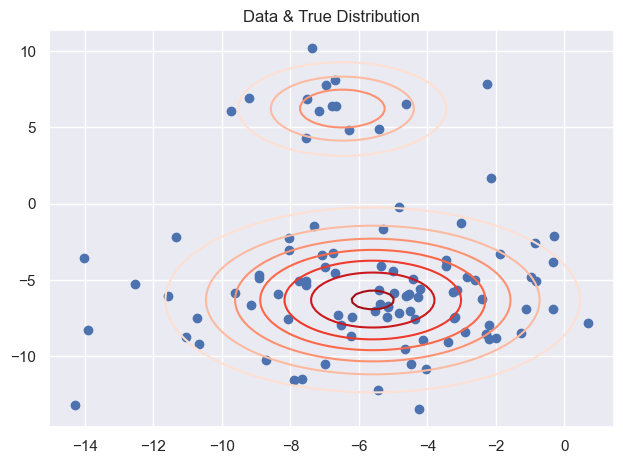

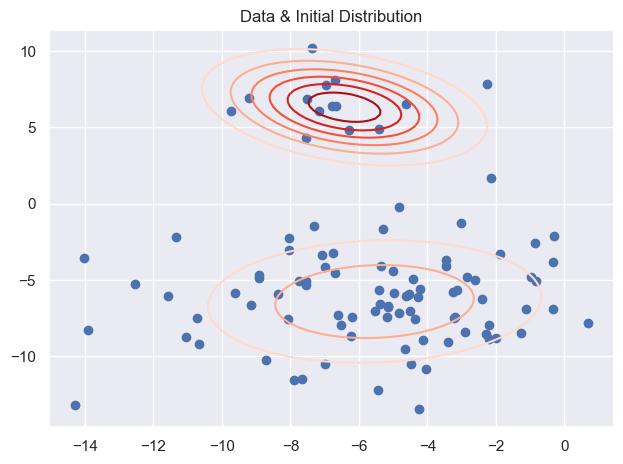

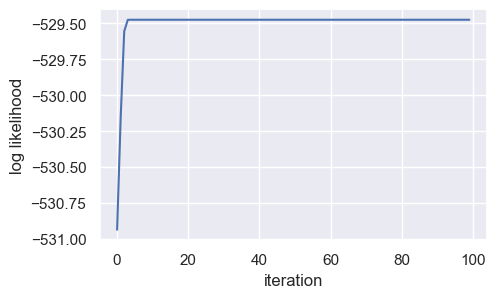

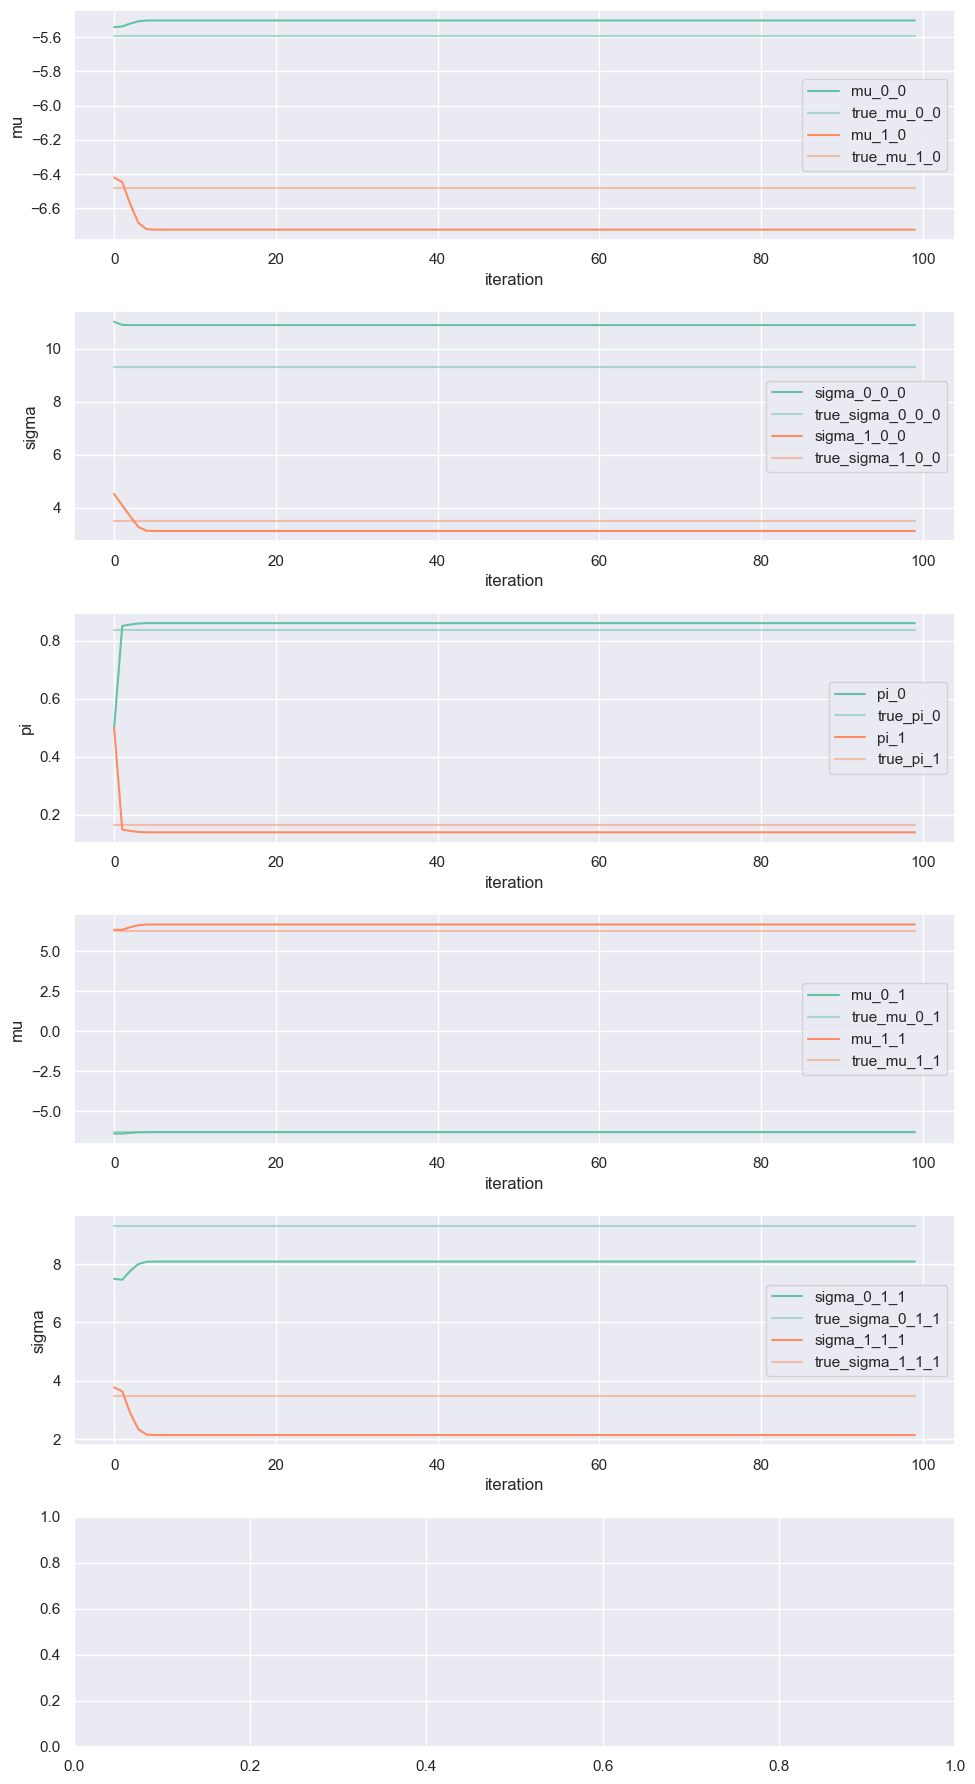

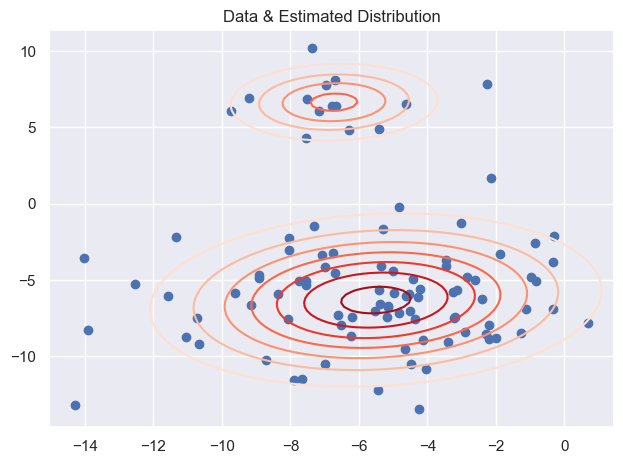

In [74]:
K = 2
N = 100
D = 2

rng = np.random.default_rng(123)

true_params = params_generator(rng, D, K)
data = generate_sample_gm(rng, true_params, N)
print(f"true: {true_params}")
fig, ax = plt.subplots()

if D == 1:
    # plot data
    sns.histplot(data, bins=30, ax=ax, stat='density')
    # plot true distribution
    x = np.linspace(*ax.get_xlim(), 100)
    density = np.zeros((len(x), ))
    for k in range(K):
        density += true_params.pi[k] * multivariate_normal.pdf(x, true_params.mu[k], true_params.sigma[k])
    ax.plot(x, density, label="mixed density")
    for k in range(K):
        ax.plot(x, multivariate_normal.pdf(x, true_params.mu[k], true_params.sigma[k]), label=f"component {k}")
    ax.legend()
    ax.set_title("Data & True Distribution")
    fig.tight_layout()
if D == 2:
    # plot data
    ax.scatter(data[:, 0], data[:, 1])
    # plot true distribution
    x1 = np.linspace(*ax.get_xlim(), 100)
    x2 = np.linspace(*ax.get_ylim(), 100)
    X1, X2 = np.meshgrid(x1, x2)
    density = np.zeros((len(x1), len(x2)))
    for k in range(K):
        density += true_params.pi[k] * multivariate_normal.pdf(np.stack([X1, X2], axis=2), true_params.mu[k], true_params.sigma[k])
    ax.contour(X1, X2, density, cmap='Reds')
    ax.set_title("Data & True Distribution")
    fig.tight_layout()


# initial = params_generator(rng, D, K)
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=K, random_state=123).fit(data)
initial = Params(
    pi=np.array([1/K]*K),
    mu=kmeans.cluster_centers_,
    sigma=[np.cov(data[kmeans.labels_ == k], rowvar=False) for k in range(K)]
)
print(f"init: {initial}")
if D == 2:
    fig, ax = plt.subplots()
    # plot data
    ax.scatter(data[:, 0], data[:, 1])
    # plot true distribution
    x1 = np.linspace(*ax.get_xlim(), 100)
    x2 = np.linspace(*ax.get_ylim(), 100)
    X1, X2 = np.meshgrid(x1, x2)
    density = np.zeros((len(x1), len(x2)))
    for k in range(K):
        density += initial.pi[k] * multivariate_normal.pdf(np.stack([X1, X2], axis=2), initial.mu[k], initial.sigma[k])
    ax.contour(X1, X2, density, cmap='Reds')
    ax.set_title("Data & Initial Distribution")
    fig.tight_layout()


EM_MAX_ITR = 100

params = initial
ll_list = []
params_list = []
for _ in tqdm(range(EM_MAX_ITR)):
    params_list.append(params)
    gamma = E_step(data, params)
    params = modified_M_step(data, gamma)
    ll_list.append(marginal_log_likelihood(data, params))
    # if len(ll_list) > 1 and ll_list[-1] - ll_list[-2] < 1e-6:
    #     break

print(f"estimated: {params}")

# plot log likelihood
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.set_xlabel("iteration")
ax.set_ylabel("log likelihood")
sns.lineplot(ll_list, ax=ax)
# plot params_list
num_axs = D*3
fig, axs = plt.subplots(num_axs, 1, figsize=(10, 3*num_axs))
axs = axs.reshape(D, 3)
colors = sns.color_palette("Set2", K)
# mu
for i in range(D):
    for k in range(K):
        axs[i][0].plot([params.mu[k][i] for params in params_list], label=f"mu_{k}_{i}", c=colors[k])
        axs[i][0].plot([true_params.mu[k][i]]*len(params_list), label=f"true_mu_{k}_{i}", alpha=0.5, c=colors[k])
    axs[i][0].set_xlabel("iteration")
    axs[i][0].set_ylabel("mu")
    axs[i][0].legend()

# diag of sigma
for i in range(D):
    for k in range(K):
        axs[i][1].plot([params.sigma[k][i][i] for params in params_list], label=f"sigma_{k}_{i}_{i}", c=colors[k])
        axs[i][1].plot([true_params.sigma[k][i][i]]*len(params_list), label=f"true_sigma_{k}_{i}_{i}", alpha=0.5, c=colors[k])
    axs[i][1].set_xlabel("iteration")
    axs[i][1].set_ylabel("sigma")
    axs[i][1].legend()

# pi
for k in range(K):
    axs[0][2].plot([params.pi[k] for params in params_list], label=f"pi_{k}", c=colors[k])
    axs[0][2].plot([true_params.pi[k]]*len(params_list), label=f"true_pi_{k}", alpha=0.5, c=colors[k])
    axs[0][2].set_xlabel("iteration")
    axs[0][2].set_ylabel("pi")
    axs[0][2].legend()

fig.tight_layout()


if D == 2:
    fig, ax = plt.subplots()
    # plot data
    ax.scatter(data[:, 0], data[:, 1])
    # plot true distribution
    x1 = np.linspace(*ax.get_xlim(), 100)
    x2 = np.linspace(*ax.get_ylim(), 100)
    X1, X2 = np.meshgrid(x1, x2)
    density = np.zeros((len(x1), len(x2)))
    for k in range(K):
        density += params.pi[k] * multivariate_normal.pdf(np.stack([X1, X2], axis=2), params.mu[k], params.sigma[k])
    ax.contour(X1, X2, density, cmap='Reds')
    ax.set_title("Data & Estimated Distribution")
    fig.tight_layout()
